In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Reading data from CSV
xl = pd.ExcelFile('/content/drive/MyDrive/AUT 2023/DATA 512/P3/MUN_1_Cert_Pop_Summary.xlsx')

My population data was in a format where I had an excel spreadsheet with different sheets corresponding to population data for different cities in Nebraska for different years. I had to pull together data across these sheets and filter to only keep North Platte census data for population counts.

In [4]:
#Data manipulation for proper format acquisition
populations = []
date_range = np.arange(2000,2020)
column_names = ["City","County","Population"]
for date in date_range:
  pop_df = pd.read_excel(xl,str(date))
  if date != 2022:
    pop_df_rect = pop_df.iloc[2:]
  else:
    pop_df_rect = pop_df.iloc[1:]

  pop_df_rect.columns = column_names
  pop_val = pop_df_rect[pop_df_rect['City']=='North Platte']['Population']
  populations.append(pop_val.values[0])

In [5]:
#Convert to dataframe
pop_data = pd.DataFrame()
pop_data['Year'] = date_range
pop_data['Population'] = populations

In [6]:
hist_pop_data = pd.read_csv('/content/drive/MyDrive/AUT 2023/DATA 512/P3/population_1990s.csv')

In [7]:
#Merge all population counts together
pop_data_full = pd.concat([hist_pop_data, pop_data])

In [8]:
#Read cancer dataset in from manually created dataset
cancer_df = pd.read_csv('/content/drive/MyDrive/AUT 2023/DATA 512/P3/cancer_data.csv')
cancer_df.sort_values(by='Year',axis=0,inplace=True)
cancer_df.reset_index(drop=True,inplace=True)

Merging population data and cancer data for each year together

In [9]:
#Inner join on 2 dataframes
np_df = cancer_df.merge(pop_data_full,left_on='Year',right_on='Year')

In [10]:
#Scaling to account for population of North Platte only instead of the entire state of Nebraska

np_df['Total Cancer Cases'] = (np_df['Total Cancer Cases (for 100000 population)']*np_df['Population'])/100000
np_df['Lung Cancer Cases'] = (np_df['Lung Cancer Cases (for 100000 population)']*np_df['Population'])/100000
np_df['Lung Cancer Mortality'] = (np_df['Lung Cancer Mortality (for 100000 population)']*np_df['Population'])/100000

This is what it looks like

In [11]:
np_df.head()

,Year,Total Cancer Cases (for 100000 population),Lung Cancer Cases (for 100000 population),Lung Cancer Mortality (for 100000 population),Population,Total Cancer Cases,Lung Cancer Cases,Lung Cancer Mortality
0,1990,440.7,61.2,52.9,22750,100.259250,13.923000,12.034750
1,1991,456.1,56.6,47.2,22936,104.611096,12.981776,10.825792
2,1992,469.3,59.5,49.9,23138,108.586634,13.767110,11.545862
3,1993,453.3,59.6,51.4,23100,104.712300,13.767600,11.873400
4,1994,450.3,57.6,52.0,23329,105.050487,13.437504,12.131080


I first wanted to have a look at existing trends relating to lung cancer cases in Nebraska and North Platte. Taking the city level total lung cancer cases and fatalities, I plotted out a stacked bar chart showing total counts.

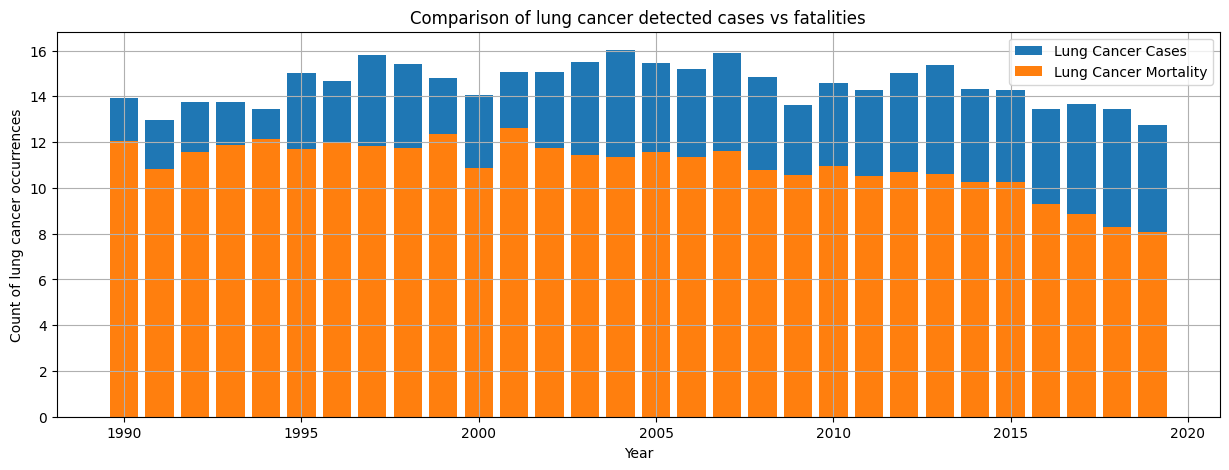

In [12]:
#Using Matplotlib functionalities for comparative analysis of total lung cancer cases versus number of fatalities

plt.figure(figsize=(15,5))
plt.bar(np_df['Year'],np_df['Lung Cancer Cases'],label='Lung Cancer Cases')
plt.bar(np_df['Year'],np_df['Lung Cancer Mortality'],label='Lung Cancer Mortality')
plt.xlabel('Year')
plt.ylabel('Count of lung cancer occurrences')
plt.title('Comparison of lung cancer detected cases vs fatalities')
plt.grid()
plt.legend()
plt.savefig('/content/drive/MyDrive/AUT 2023/DATA 512/P3/cancer-trends.png')
plt.show()

To identify correlations between smoke estimate and lung cancer, I will read in the original smoke esimtate JSON. To predict future counts of lung cancer cases, I will use a Linear Regression model with smoke estimate as a predictor

In [13]:
# Read previously created smoke estimate JSON, filter out very low values as they skew the data and group by year to get average smoke estimates.

smoke_df = pd.read_json('/content/drive/MyDrive/AUT 2023/DATA 512/P1/smoke_estimate_NP.json')
smoke_wfs = smoke_df[smoke_df['smoke_estimate']>5]
smoke_year = smoke_wfs.groupby('Fire_Year').mean()['smoke_estimate']
smoke_final = smoke_year.to_frame()
smoke_final.reset_index(inplace=True)
smoke_final.head()

<ipython-input-13-43ea2fddce20>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  smoke_year = smoke_wfs.groupby('Fire_Year').mean()['smoke_estimate']


,Fire_Year,smoke_estimate
0,1963,22.140731
1,1964,25.937501
2,1965,58.268129
3,1966,35.503025
4,1967,24.378789


In [14]:
#Inner JOIN smoke dataframe with cancer occurrences dataframe

np_smoke_df = np_df.merge(smoke_final,left_on='Year',right_on='Fire_Year')

In [15]:
np_smoke_df.head()

,Year,Total Cancer Cases (for 100000 population),Lung Cancer Cases (for 100000 population),Lung Cancer Mortality (for 100000 population),Population,Total Cancer Cases,Lung Cancer Cases,Lung Cancer Mortality,Fire_Year,smoke_estimate
0,1990,440.7,61.2,52.9,22750,100.259250,13.923000,12.034750,1990,30.956309
1,1991,456.1,56.6,47.2,22936,104.611096,12.981776,10.825792,1991,23.985246
2,1992,469.3,59.5,49.9,23138,108.586634,13.767110,11.545862,1992,30.046588
3,1993,453.3,59.6,51.4,23100,104.712300,13.767600,11.873400,1993,21.579479
4,1994,450.3,57.6,52.0,23329,105.050487,13.437504,12.131080,1994,25.907065


Correlation plot of smoke estimate and cancer cases

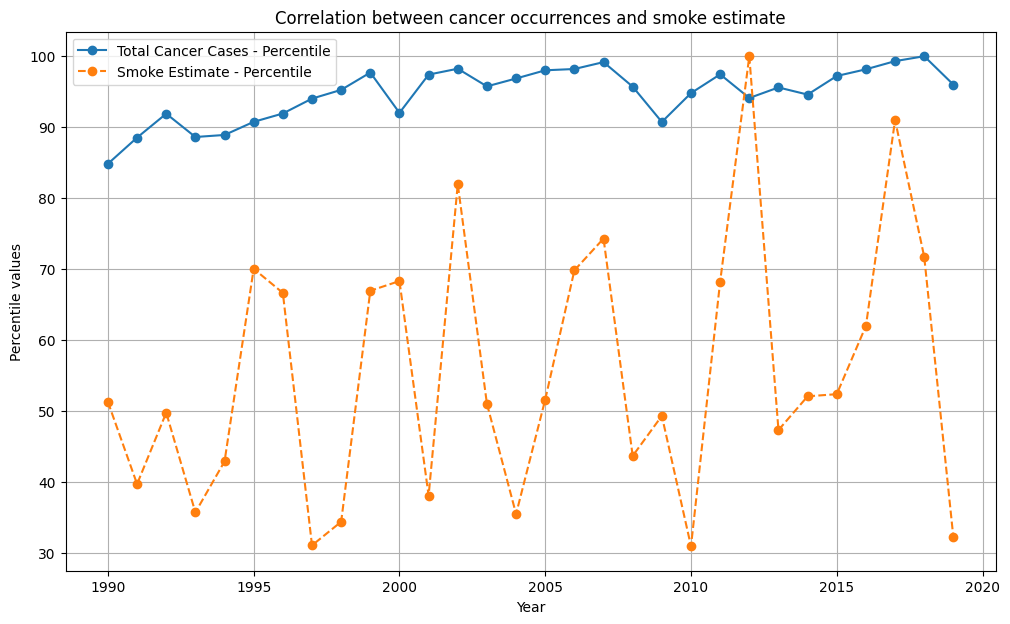

In [16]:
#Percentile values are used for similar scaling here

plt.figure(figsize=(12,7))
plt.plot(np_smoke_df['Year'],np_smoke_df['Total Cancer Cases']*100/max(np_smoke_df['Total Cancer Cases']),label='Total Cancer Cases - Percentile',marker='o',linestyle='-')
plt.plot(np_smoke_df['Year'],np_smoke_df['smoke_estimate']*100/max(np_smoke_df['smoke_estimate']),label='Smoke Estimate - Percentile',marker='o',linestyle='--')
plt.xlabel('Year')
plt.ylabel('Percentile values')
plt.title('Correlation between cancer occurrences and smoke estimate')
plt.grid()
plt.legend()
plt.savefig('/content/drive/MyDrive/AUT 2023/DATA 512/P3/cancer-smoke-correlations.png')
plt.show()

Numeric correlation value is obtained as well. A score > 0 indicates positive correlation

In [17]:
#Pearsons correlation coefficient used

np_smoke_df['Total Cancer Cases'].corr(np_smoke_df['smoke_estimate'],method='pearson')

0.3142958370535788

Linear Regression on smoke estimate to find future cancer cases counts

In [18]:
#Using SKlearns Linear Regression model

from sklearn.linear_model import LinearRegression
X = np.array(np_smoke_df['smoke_estimate']).reshape(-1,1)
y = np.array(np_smoke_df['Total Cancer Cases']).reshape(-1,1)
reg = LinearRegression().fit(X, y)

In [19]:
#Read in previously created smoke estimate predictions df

smoke_preds = pd.read_csv('/content/drive/MyDrive/AUT 2023/DATA 512/P1/future_predicted_smoke_estimate.csv')

smoke_preds.head()

,Unnamed: 0,ds,yhat
0,61,2024-01-01,62.570276
1,62,2025-01-01,52.659502
2,63,2026-01-01,45.805366
3,64,2027-01-01,42.736179
4,65,2028-01-01,63.910609


In [20]:
#Some manipulations to get proper formats

x_pred = np.array(smoke_preds['yhat']).reshape(-1,1)
y_pred = reg.predict(x_pred)

In [21]:
#Datetime conversions to separate year out

ds_dt = pd.to_datetime(smoke_preds['ds'])
future_year = ds_dt.dt.year
cancer_preds = future_year.to_frame()

In [22]:
cancer_preds['Cancer Cases'] = y_pred

In [24]:
cancer_preds.to_csv('/content/drive/MyDrive/AUT 2023/DATA 512/P3/future_cancer_predictions.csv',index=False)

Time Series Forecasting plotting of future lung cancer cases

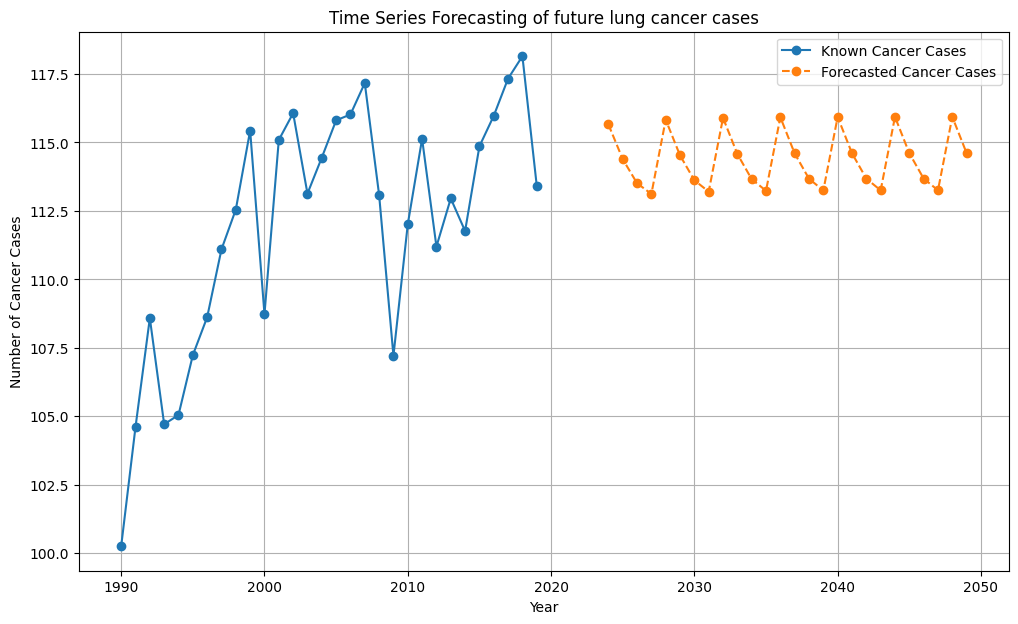

In [25]:
#using dotted values to show future predictions and solid line to show pre existing values

plt.figure(figsize=(12,7))
plt.plot(np_smoke_df['Year'],np_smoke_df['Total Cancer Cases'],label='Known Cancer Cases',marker='o',linestyle='-')
plt.plot(cancer_preds['ds'],cancer_preds['Cancer Cases'],label='Forecasted Cancer Cases',marker='o',linestyle='--')
plt.xlabel('Year')
plt.ylabel('Number of Cancer Cases')
plt.title('Time Series Forecasting of future lung cancer cases')
plt.grid()
plt.legend()
plt.savefig('/content/drive/MyDrive/AUT 2023/DATA 512/P3/forecasted-cancer-cases.png')
plt.show()